# SEP 769- Deep Learning Project- Optimizing Energy Usage in Buildings Using IoT Data and Deep Learning Algorithms
> Hongqing Cao 400053625  
Sushant Shailesh Panchal 400614293  
Yanyi He 400651032  
Yash Parab 400611922

## Introduction
This project aims to develop a machine learning-based system to optimize energy usage in buildings using data from IoT sensors. The goal is to reduce energy consumption and costs while maintaining occupant comfort and health. The project involves preprocessing data from IoT sensors, developing a deep learning model to optimize energy usage, and testing the model on new data to evaluate its effectiveness.

The dataset [**Individual Household Electric Power Consumption dataset**](https://archive.ics.uci.edu/dataset/235) is retrived from UCI Machine Learning Repository, which contains measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

### Objectives
- Compare two different models over a subset of dataset, find the better performed model. 
- Tune, train, and evaluate the selected model, use this model to forecast future power consumption. 
- Visualize the predicted vs actual load, identify peak/vally power load time frames to suggest grid operation. 


### Dataset
- **Source**: UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/235).
- **Information**: This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). 

- **Features**: 
    - `date: dd/mm/yyyy`
    - `time: hh:mm:ss`
    - `global_active_power: float` Total household active power usage in kilowatts (kW)
    - `reactive_power: float` Power not used for work, in KW
    - `voltage: float` Voltage across the circuit, in V
    - `global_intensity: float` Current drawn, in A
    - `sub_metering_1: float` Energy drawn for kitchen, in Wh
    - `sub_metering_2: float` Energy drawn for laundry, in Wh
    - `sub_metering_3: float` Energy drawn for water heater and AC, in Wh
-
- **Note**:  
`global_active_power * 1000 / 60- sub_metering_1- sub_metering_2- sub_metering_3`  
represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.
-
- **Missing Data**: The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing (willed with `?`). 

### References
- Marino et al. (2016), *Building Energy Load Forecasting using Deep Neural Networks*. -
- Bonetto & Rossi (2017), *Machine Learning Approaches to Energy Consumption Forecasting in Households*. -
- Gasparin et al. (2019), *Deep Learning for Time Series Forecasting: The Electric Load Case*. 

### Essential Notes
- **Hardware**: The code in notebook in designed to best perform with CUDA GPUs, targeting RTX 4070. 
-
- **Environment**: Use `Python 3.11.7`, `NVIDIA-SMI 575.64.04`, `Driver Version: 577.00`, `CUDA Version: 12.9`. 

## 0. Environment Setup
### Libaries Imported
`numpy 2.1.3`  
`matplotlib 3.10.3`  
`pandas 2.3.1`  
`tensorflow 2.19.0`  
`scikit-learn 1.7.1`  
`keras 3.10.0`  
`tensorboard 2.19.0`  
`seaborn 0.13.2`  

### GPU Config
set `set_memory_growth`, `mixed_precision`

### Utility Functions
``

In [1]:
### Libaries Imported
from os import path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from keras import Sequential, layers, Model, regularizers
from keras import backend as K
from keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import mixed_precision
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc

%load_ext tensorboard

np.random.seed(42)

2025-08-03 18:43:17.722651: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-03 18:43:17.857903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754260997.908497    2422 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754260997.923581    2422 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754260998.038647    2422 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
### GPU Config
# use set_memory_growth to aallocate VRAM

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# use mixed_precision to accelrate GPU speed

mixed_precision.set_global_policy('mixed_float16')

In [3]:
### Global Variables
DATA_DIR = "data"
RAW_DIR = DATA_DIR+"/raw"
TRAIN_DIR = DATA_DIR+"/train"
TEST_DIR = DATA_DIR+"/test"

MODEL_DIR = "model"

LOG_DIR = "log"
HPARAM_DIR = LOG_DIR+"/hparam"

In [4]:
### Utility functions

def delete_model(modelname, historyname):
    '''function for delete model, history and free vram'''
    global_vars = globals()
    if modelname in globals():
        del global_vars[modelname]
    if historyname in globals():
        del global_vars[historyname]
    gc.collect()
    K.clear_session()

def check_point(model_name, monitor = 'val_loss', save_best_only = True, hparam = False):
    
    model_dir = MODEL_DIR + '/' + model_name + '.keras'
    if hparam:
        model_dir = 'hparam/' + model_dir
    return ModelCheckpoint(
        model_dir,
        monitor=monitor,
        save_best_only=save_best_only
    )

def early_stop(patience, monitor='val_loss',restore_best_weights=True):
    return EarlyStopping(
        monitor=monitor,
        patience=patience,
        restore_best_weights=restore_best_weights
    )

def inspect_data(df, name):
    '''print summary data of a given dataframe, with
    count
    mean
    std
    min
    25%
    50%
    75%
    max
    dtype
    '''
    print(f"\n{name} summary:")
    print(df.describe())
    print(df.isnull().sum())

def plot_time_series(df, column, start=None, end=None, title=None):
    '''plot the raw time series data from time to end with corresponding column

    column =  global_active_power, sub_metering_other, sub_metering_1/2/3'''
    df_subset = df[start:end] if start or end else df
    df_subset[column].plot(figsize=(12, 4), title=title or column)

def plot_loss(history, maxy=None):
    '''Loss during training'''
    loss = history['loss']
    test_loss = history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, label = 'train loss')
    plt.plot(epochs, test_loss, label = 'val loss')
    if maxy:
        plt.ylim(max(0, min(test_loss) - 0.05), maxy)
    plt.legend()
    plt.title('Loss')
    plt.grid()
    plt.figure()

def plot_forecast(y_true, y_pred, title="Forecast vs Actual"):
    '''plot forecast vs actual lines'''
    plt.figure(figsize=(12, 4))
    plt.plot(y_true, label="Actual")
    plt.plot(y_pred, label="Forecast")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_average_forecast(y_true, y_pred , title="Averaged Forecast vs Ground Truth"):
    """
    Visualize average forecasts vs truth.
    """
    y_true = y_true.reshape(y_true.shape[0], 24)
    y_pred = y_pred.reshape(y_pred.shape[0], 24)
    num_windows, forecast_horizon = y_pred.shape
    total_len = num_windows + forecast_horizon - 1

    avg_preds = np.zeros(total_len)
    counts = np.zeros(total_len)

    # Average overlapping predictions
    for i in range(num_windows - 1):
        for j in range(forecast_horizon):
            t = i + j
            avg_preds[t] += y_pred[i, j]
            counts[t] += 1

    # Prevent division by zero
    counts[counts == 0] = 1
    avg_preds /= counts

    # Flatten ground truth
    y_true_flat = y_true.flatten()
    y_aligned = y_true_flat[:total_len]

    plt.figure(figsize=(12, 4))
    plt.plot(y_aligned, label="True", alpha=0.8)
    plt.plot(avg_preds, label="Predicted (avg)", alpha=0.8)
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Target Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [52]:
def plot_forecast_error(y_test, y_pred):
    errors = np.abs(y_pred.squeeze() - y_test.squeeze())  # (samples, 24)
    mae_per_step = np.mean(errors, axis=0)

    plt.figure(figsize=(10, 4))
    plt.plot(range(1, 24), mae_per_step, marker='o')
    plt.title("Error over Forecast Horizon (MAE)")
    plt.xlabel("Step Ahead (Hours)")
    plt.ylabel("Mean Absolute Error")
    plt.grid(True)
    plt.xticks(range(1, 24))
    plt.tight_layout()
    plt.show()


def plot_forecast_MSE(y_test, y_pred):
    errors = np.square(y_pred.squeeze() - y_test.squeeze())  # (samples, 24)
    mse_per_step = np.mean(errors, axis=0)

    plt.figure(figsize=(10, 4))
    plt.plot(range(1, 24), mse_per_step, marker='o')
    plt.title("Error over Forecast Horizon (MSE)")
    plt.xlabel("Step Ahead (Hours)")
    plt.ylabel("Mean Absolute Error")
    plt.grid(True)
    plt.xticks(range(1, 24))
    plt.tight_layout()
    plt.show()

## 1. Data Preprocessing

### Load Data
- Load raw dataset
- Convert data type

### Resample Data
Resample data to 1-hr

### Handle Missing Data
Reconstruct misssing data with linear interpolation

### Save Raw Data
Save to `data/raw`

### Feature Engineering
- `season_spring: binary` one-hot coded season transformed from `date`
- `season_summer: binary` one-hot coded season transformed from `date`
- `season_autumn: binary` one-hot coded season transformed from `date`
- `season_winter: binary` one-hot coded season transformed from `date`
- `day_of_week: int` categorical in `range(7)`, 0 Sunday, 1 Monday, 6 Saturday
- `hour_sin, hour_cos: float` hour in transfromed from `time` in cyclical encoding, range [-1, 1]
- `global_active_power: float` target variable, 
- `sub_metering_other: float` calculated by `global_active_power * 1000 / 60- sub_metering_1- sub_metering_2- sub_metering_3`, 
- `reactive_power: float` drop
- `voltage: float` drop
- `global_intensity: float` drop
- `sub_metering_1: float` existing raw feature
- `sub_metering_2: float` existing raw feature
- `sub_metering_3: float` existing raw feature

### Save Feature Engineered Data
Save to `data/raw`

### Create Subsets (distinct)
- `model_selection`: 3 month (~2100 samples)
- `hparam_tuning`: 3 month (~2100 samples)
- `train`: 24 months (~17000 samples)
- `test`: 3 months (~2100 samples)
- `test_1`: 3 months (~2100 samples) forecast
- `test_2`: 3 months (~2100 samples) forecast

### Save Subset Data
- Store model selection, tuning, training data in `data/train` 
- Store  testing data in `data/test` 

### Normalization and Standarization
Use `StandardScaler` for `global_active_power`, `sub_metering_other`, `sub_metering_1`, `sub_metering_2`, `sub_metering_3` 

### Save Normalized Data
Store model selection, tuning, training data in `data/train` 

### Lagging Data
- Lag X by 1 week = 168 hrs = 168 steps.  
- Lag y by 1 day = 24 hrs = 24 steps.  
- Specify target variable 

### Save Final Processed Data
- Store raw data in `/data/raw` 
- Store model selection, tuning, training data in `data/train` 
- Store  testing data in `data/test` 
- Store models in `model` 
- Store hyperparameter tuning log in `log/hparam`. 

In [22]:
### Load Data
# Load raw data
chunks = []
reader = pd.read_csv(
    RAW_DIR+"/household_power_consumption.txt", 
    sep=";", 
    na_values='?',
    low_memory=False,
    chunksize=500_000
    )

for chunk in reader:
    chunks.append(chunk)

df = pd.concat(chunks)

df.columns = df.columns.str.lower()
df['datetime_str'] = df['date'] + ' ' + df['time']

df['datetime'] = (pd.to_datetime(df['datetime_str'], dayfirst=True))
df = df.drop(columns=['date', 'time', 'datetime_str'])
df.set_index("datetime", inplace=True)
df.sort_index(inplace=True)

# Convert from string/object to float
df = df.astype(np.float32)

In [6]:
inspect_data(df, 'raw data')


raw data summary:
       global_active_power  global_reactive_power       voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237144e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       global_intensity  sub_metering_1  sub_metering_2  sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627760e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%    

In [23]:
### Resample Data
# Resample to hourly mean
df_hourly = df.resample('h').mean()

In [24]:
### Handle Missing Data
df_hourly_reco = df_hourly.interpolate(method='linear', limit_direction='both')
df_hourly_reco.dropna(inplace=True)

In [25]:
inspect_data(df_hourly_reco, 'reconstructed data')


reconstructed data summary:
       global_active_power  global_reactive_power       voltage  \
count         34589.000000           34589.000000  34589.000000   
mean              1.092488               0.123710    240.828400   
std               0.895746               0.066998      3.002928   
min               0.124000               0.000000    225.834503   
25%               0.343433               0.078067    239.174835   
50%               0.806833               0.106833    240.974670   
75%               1.578233               0.149367    242.687668   
max               6.560533               0.774333    251.902008   

       global_intensity  sub_metering_1  sub_metering_2  sub_metering_3  
count      34589.000000    34589.000000    34589.000000    34589.000000  
mean           4.631340        1.123029        1.291784        6.445877  
std            3.749644        3.534986        4.170525        7.332015  
min            0.503333        0.000000        0.000000        0.000000

In [26]:
# Save raw data
df_hourly_reco.to_pickle(RAW_DIR+"/hourly_reco.pkl")


In [27]:
# Load raw data
df_hourly_reco = pd.read_pickle(RAW_DIR+"/hourly_reco.pkl")

In [28]:
### Feature Engineering
df_hourly_reco['month'] = df_hourly_reco.index.month
df_hourly_reco['season'] = df_hourly_reco.index.month % 12 // 3 
# 1=spring, 2=summer, 3=fall, 0=winter

season_map = {0: 'winter', 1: 'spring', 2: 'summer', 3: 'autumn'}
df_hourly_reco['season_label'] = df_hourly_reco['season'].map(season_map)

df_hourly_reco = pd.get_dummies(df_hourly_reco, columns=['season_label'], prefix='season')

dow_mon0 = df_hourly_reco.index.dayofweek # 0=Monday
dow_sun0 = (dow_mon0 + 1) % 7 # 0=Sunday
df_hourly_reco['day_of_week'] = dow_sun0 # 0=Sunday


df_hourly_reco['hour'] = df_hourly_reco.index.hour
# For smoother time-of-day signals:
df_hourly_reco['hour_sin'] = np.sin(2 * np.pi * df_hourly_reco['hour'] / 24)
df_hourly_reco['hour_cos'] = np.cos(2 * np.pi * df_hourly_reco['hour'] / 24)

df_hourly_reco['sub_metering_other'] = (
    df_hourly_reco['global_active_power'] * 1000 / 60
    - df_hourly_reco['sub_metering_1']
    - df_hourly_reco['sub_metering_2']
    - df_hourly_reco['sub_metering_3']
)

df_fe = df_hourly_reco.copy()

In [29]:
### Feature Engineering Continued
drop_cols = ['month', 'season', 'hour', 'voltage', 'global_reactive_power', 'global_intensity']
df_fe.drop(columns=drop_cols, inplace=True)

In [30]:
inspect_data(df_fe, 'feature engineered data')


feature engineered data summary:
       global_active_power  sub_metering_1  sub_metering_2  sub_metering_3  \
count         34589.000000    34589.000000    34589.000000    34589.000000   
mean              1.092488        1.123029        1.291784        6.445877   
std               0.895746        3.534986        4.170525        7.332015   
min               0.124000        0.000000        0.000000        0.000000   
25%               0.343433        0.000000        0.000000        0.650000   
50%               0.806833        0.000000        0.333333        1.666667   
75%               1.578233        0.000000        0.650000       14.066667   
max               6.560533       48.366665       46.433334       21.549999   

        day_of_week      hour_sin      hour_cos  sub_metering_other  
count  34589.000000  34589.000000  3.458900e+04        34589.000000  
mean       2.998410     -0.000130  3.489857e-05            9.347441  
std        1.999414      0.707150  7.070840e-01      

In [31]:
### Save Feature Engineered Data
df_fe.to_pickle(RAW_DIR+"/feature_engineered.pkl")


In [32]:
### Load Feature Engineered Data
df_fe=pd.read_pickle(RAW_DIR+"/feature_engineered.pkl")

In [33]:
df_fe.iloc[0]

global_active_power     4.222889
sub_metering_1               0.0
sub_metering_2          0.527778
sub_metering_3         16.861111
season_autumn              False
season_spring              False
season_summer              False
season_winter               True
day_of_week                    6
hour_sin               -0.965926
hour_cos               -0.258819
sub_metering_other     52.992596
Name: 2006-12-16 17:00:00, dtype: object

In [34]:
### Create Subsets (distinct)
total_len = len(df_fe)

# Subset sizes (in number of rows)
model_sel_len = 2160     # 3 month
tune_len      = 2160     # 3 month
train_len     = 17520    # 24 months
test_len      = 2160    # 3 months

# Sequential slicing
model_sel_df = df_fe.iloc[:model_sel_len]

tune_df = df_fe.iloc[model_sel_len : model_sel_len + tune_len]

train_df = df_fe.iloc[model_sel_len + tune_len : model_sel_len + tune_len + train_len]

test_df = df_fe.iloc[model_sel_len + tune_len + train_len : model_sel_len + tune_len + train_len + test_len]

test1_start = 27000

test1_df = df_fe[test1_start : test1_start + test_len]
test2_df = df_fe[test1_start + test_len + test_len : test1_start + test_len + test_len + test_len]


In [35]:
### Save Subsets
model_sel_df.to_pickle(TRAIN_DIR+"/model_selection.pkl")
tune_df.to_pickle(TRAIN_DIR+"/hparam_tuning.pkl")
train_df.to_pickle(TRAIN_DIR+"/train.pkl")
test_df.to_pickle(TEST_DIR+"/test.pkl")
test1_df.to_pickle(TEST_DIR+"/test1.pkl")
test2_df.to_pickle(TEST_DIR+"/test2.pkl")


In [36]:
### Load Subsets
model_sel_df = pd.read_pickle(TRAIN_DIR+"/model_selection.pkl")
tune_df = pd.read_pickle(TRAIN_DIR+"/hparam_tuning.pkl")
train_df = pd.read_pickle(TRAIN_DIR+"/train.pkl")
test_df = pd.read_pickle(TEST_DIR+"/test.pkl")
test1_df = pd.read_pickle(TEST_DIR+"/test1.pkl")
test2_df = pd.read_pickle(TEST_DIR+"/test2.pkl")

In [37]:
[model_sel_df.shape, tune_df.shape, train_df.shape, test_df.shape, test1_df.shape, test2_df.shape]

[(2160, 12), (2160, 12), (17520, 12), (2160, 12), (2160, 12), (2160, 12)]

In [38]:
### Normalization and Standarization
cols_to_scale = ['global_active_power', 'sub_metering_other', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']

scaler = StandardScaler()
scaler.fit(train_df[cols_to_scale])

def std_scale(df, scaler, cols_to_scale):
    df_scaled = df.copy()
    df_scaled[cols_to_scale] = scaler.transform(df[cols_to_scale])
    return df_scaled


model_sel_scaled = std_scale(model_sel_df, scaler, cols_to_scale)
tune_scaled = std_scale(tune_df, scaler, cols_to_scale)
train_scaled = std_scale(train_df, scaler, cols_to_scale)
test_scaled = std_scale(test_df, scaler, cols_to_scale)
test1_scaled = std_scale(test1_df, scaler, cols_to_scale)
test2_scaled = std_scale(test2_df, scaler, cols_to_scale)

In [39]:
### Save Normalized Data
model_sel_scaled.to_pickle(TRAIN_DIR+"/model_selection_scaled.pkl")
tune_scaled.to_pickle(TRAIN_DIR+"/hparam_tuning_scaled.pkl")
train_scaled.to_pickle(TRAIN_DIR+"/train_scaled.pkl")
test_scaled.to_pickle(TEST_DIR+"/test_scaled.pkl")
test1_scaled.to_pickle(TEST_DIR+"/test1_scaled.pkl")
test2_scaled.to_pickle(TEST_DIR+"/test2_scaled.pkl")


In [40]:
### Load Normalized Data
model_sel_scaled = pd.read_pickle(TRAIN_DIR+"/model_selection_scaled.pkl")
tune_scaled = pd.read_pickle(TRAIN_DIR+"/hparam_tuning_scaled.pkl")
train_scaled = pd.read_pickle(TRAIN_DIR+"/train_scaled.pkl")
test_scaled = pd.read_pickle(TEST_DIR+"/test_scaled.pkl")
test1_scaled = pd.read_pickle(TEST_DIR+"/test1_scaled.pkl")
test2_scaled = pd.read_pickle(TEST_DIR+"/test2_scaled.pkl")

In [41]:
train_scaled.columns

Index(['global_active_power', 'sub_metering_1', 'sub_metering_2',
       'sub_metering_3', 'season_autumn', 'season_spring', 'season_summer',
       'season_winter', 'day_of_week', 'hour_sin', 'hour_cos',
       'sub_metering_other'],
      dtype='object')

In [42]:
### Lagging Data

def create_lagged_sequences(df, target_col, lag_size=168, forecast_horizon=24):
    features = df.drop(columns=[target_col]).values
    target = df[target_col].values

    num_samples = len(df)- lag_size- forecast_horizon + 1
    num_features = features.shape[1]

    X = np.zeros((num_samples, lag_size, num_features), dtype=np.float32)
    y = np.zeros((num_samples, forecast_horizon, 1), dtype=np.float32)

    for i in range(num_samples):
        X[i] = features[i : i + lag_size]
        y[i,:,0] = target[i + lag_size : i + lag_size + forecast_horizon]

    return X, y


In [43]:

target_col='global_active_power'


X_model_sel, y_model_sel = create_lagged_sequences(model_sel_scaled, target_col)
X_tune, y_tune = create_lagged_sequences(tune_scaled, target_col)
X_train, y_train = create_lagged_sequences(train_scaled, target_col)
X_test, y_test = create_lagged_sequences(test_scaled, target_col)
X_test1, y_test1 = create_lagged_sequences(test1_scaled, target_col)
X_test2, y_test2= create_lagged_sequences(test2_scaled, target_col)

In [44]:
### Save Processed Data
np.save(TRAIN_DIR+"/X_model_sel.npy", X_model_sel)
np.save(TRAIN_DIR+"/y_model_sel.npy", y_model_sel)
np.save(TRAIN_DIR+"/X_tune.npy", X_tune)
np.save(TRAIN_DIR+"/y_tune.npy", y_tune)
np.save(TRAIN_DIR+"/X_train.npy", X_train)
np.save(TRAIN_DIR+"/y_train.npy", y_train)
np.save(TRAIN_DIR+"/X_test.npy", X_test)
np.save(TRAIN_DIR+"/y_test.npy", y_test)
np.save(TRAIN_DIR+"/X_test1.npy", X_test1)
np.save(TRAIN_DIR+"/y_test1.npy", y_test1)
np.save(TRAIN_DIR+"/X_test2.npy", X_test2)
np.save(TRAIN_DIR+"/y_test2.npy", y_test2)

In [45]:
### Load Processed Data
X_model_sel = np.load(TRAIN_DIR+"/X_model_sel.npy")
y_model_sel = np.load(TRAIN_DIR+"/y_model_sel.npy")

X_tune = np.load(TRAIN_DIR+"/X_tune.npy")
y_tune = np.load(TRAIN_DIR+"/y_tune.npy")

X_train = np.load(TRAIN_DIR+"/X_train.npy")
y_train = np.load(TRAIN_DIR+"/y_train.npy")

X_test = np.load(TRAIN_DIR+"/X_test.npy")
y_test = np.load(TRAIN_DIR+"/y_test.npy")

X_test1 = np.load(TRAIN_DIR+"/X_test1.npy")
y_test1 = np.load(TRAIN_DIR+"/y_test1.npy")

X_test2 = np.load(TRAIN_DIR+"/X_test2.npy")
y_test2 = np.load(TRAIN_DIR+"/y_test2.npy")

In [46]:
[(X_model_sel.shape, y_model_sel.shape), (X_tune.shape, y_tune.shape), (X_train.shape, y_train.shape), (X_test.shape, y_test.shape), (X_test1.shape, y_test1.shape), (X_test2.shape, y_test2.shape)]

[((1969, 168, 11), (1969, 24, 1)),
 ((1969, 168, 11), (1969, 24, 1)),
 ((17329, 168, 11), (17329, 24, 1)),
 ((1969, 168, 11), (1969, 24, 1)),
 ((1969, 168, 11), (1969, 24, 1)),
 ((1969, 168, 11), (1969, 24, 1))]

## 2. Model Selection
Train both model with `model_selection` subset with `validation_split = 0.2`. 

### LSTM
- Design a LSTM model with such layers:
    - An Input specifier to ensure input shape (None, 168, 11)
    - A LSTM layer with 64 Gated Memory Cells
    - A Dropout layer to drop out 20% of parameters
    - A Dense layer with 32 units and ReLU activation function
    - A Dense layer with 24 units for linear output

- Compile with such hyperparameters:
    - Adam optimizer
    - learning rate: 1e-4
    - loss: mse
    - metrics: mae

- Train with such hyperparameters:
    - validation split: 0.2
    - batch size: 32
    - no shuffle
    - early stop monitor: validation loss
    - early stop patience: 7
    - check point metric: validation loss 

### S2S
- Design a Sequence to Sequence model with such layers:
    - Encoder:
        - An Input specifier to ensure encoder shape (None, 168, 11)
        - A LSTM layer with 64 Gated Memory Cells, with L2 Regulation: 0.01
    - Decoder: 
        - An Input specifier to ensure encoder shape (None, 24, 11)
        - A LSTM layer with 64 Gated Memory Cells, with L2 Regulation: 0.01
        - A Dropout layer to drop 20% of parameters
        - A Dense layer with 24 units for linear output, with L2 Regulation: 0.01
    - IO: The hidden state and cell memory from encoder LSTM is passed to decoder LSTM as initial state. 

- Compile with such hyperparameters:
    - Adam optimizer
    - learning rate: 1e-4
    - loss: mse
    - metrics: mae

- Train with such hyperparameters:
    - validation split: 0.2
    - batch size: 32
    - no shuffle
    - early stop monitor: validation loss
    - early stop patience: 15
    - check point metric: validation loss 

### Evaluation
Use loss plot to compare model loss among epochs. 

### Save Model
Save both models in `model`


In [8]:
### LSTM
def build_LSTM(input_shape, units=64, dropout_rate=0.2, learning_rate = 0.001):
    model = Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(units),
        layers.Dropout(dropout_rate),
        layers.Dense(units=int(units/2), activation='relu'),
        layers.Dense(24)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

In [9]:
delete_model('model_sel_LSTM', 'history_sel_LSTM')

input_shape = X_model_sel.shape[1:]
output_shape = y_model_sel.shape[1:]

model_sel_LSTM = build_LSTM(input_shape)
model_sel_LSTM.summary()

I0000 00:00:1754261043.862027    2422 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,560 (84.22 KB)

 Trainable params: 21,560 (84.22 KB)

 Non-trainable params: 0 (0.00 B)

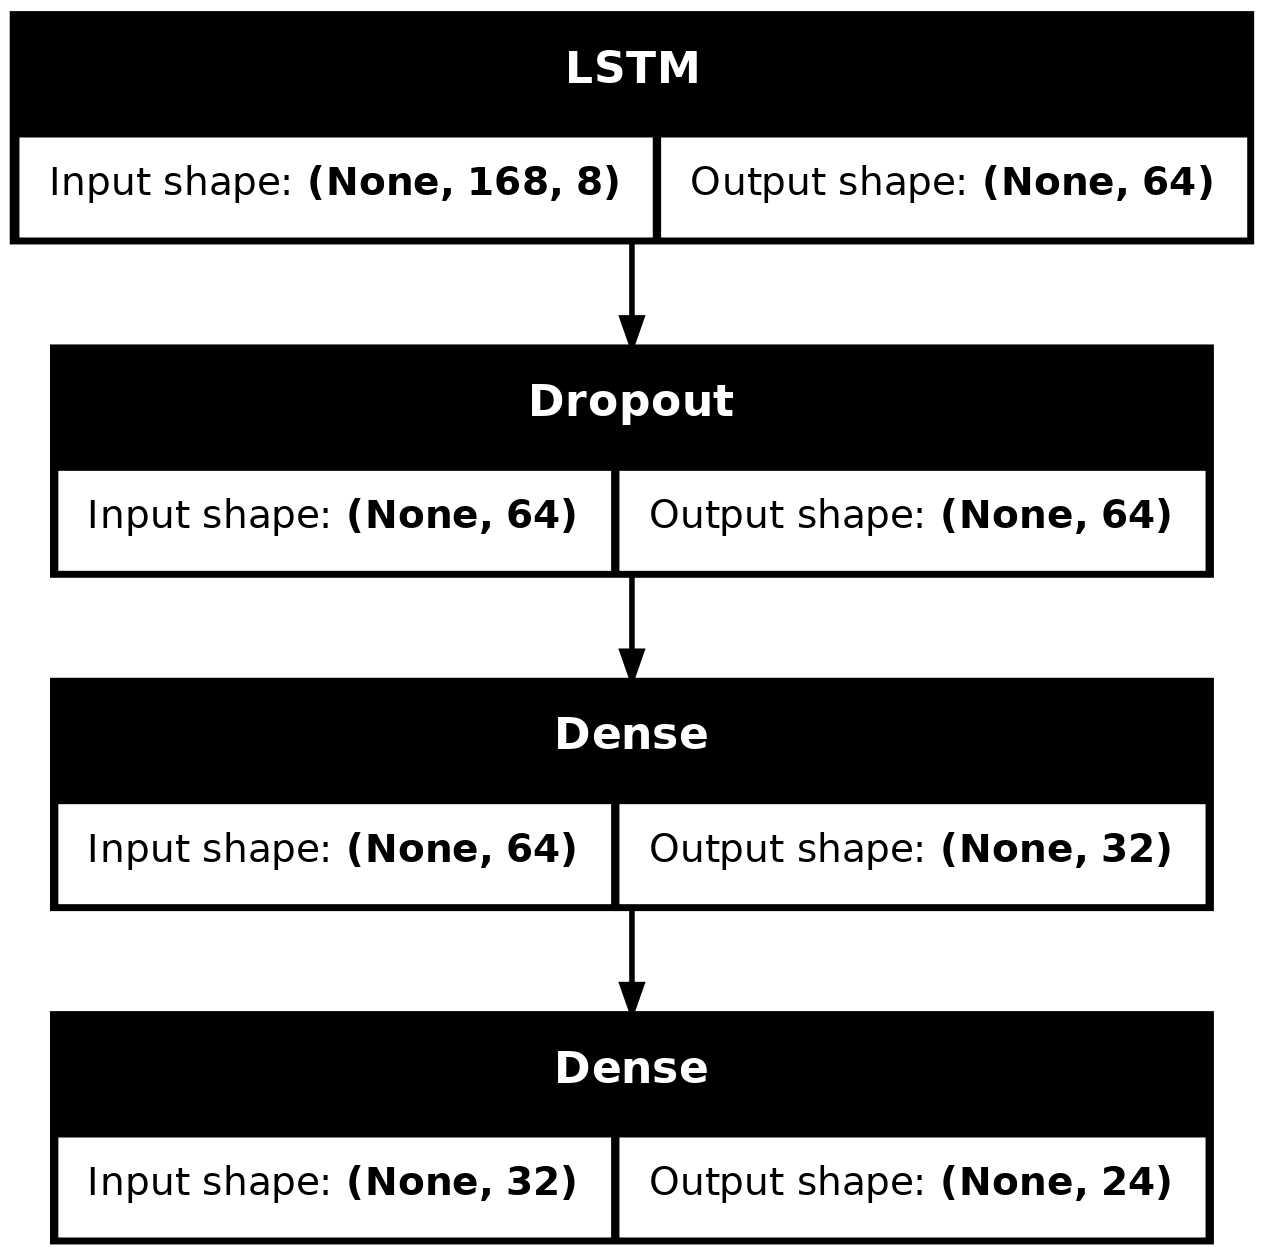

In [ ]:
keras.utils.plot_model(model_sel_LSTM, "LSTM.png", show_shapes=True)

In [255]:
### Train Each Model
history_sel_LSTM = model_sel_LSTM.fit(
    X_model_sel, y_model_sel,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    shuffle=False,
    callbacks=[check_point('model_sel_LSTM'), early_stop(7)]
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.9260 - mae: 1.1033 - val_loss: 1.4295 - val_mae: 1.0012
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.6220 - mae: 1.0352 - val_loss: 1.3672 - val_mae: 0.9826
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 1.5114 - mae: 1.0065 - val_loss: 1.3292 - val_mae: 0.9726
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.4516 - mae: 0.9837 - val_loss: 1.2863 - val_mae: 0.9583
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.3984 - mae: 0.9600 - val_loss: 1.2296 - val_mae: 0.9363
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.3585 - mae: 0.9411 - val_loss: 1.1669 - val_mae: 0.9040
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.2950 - mae: 0.9133 - val_loss: 1.1197 - val_mae: 0.8740
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.2383 - mae: 0.8853 - val_loss: 1.1344 - val_mae: 0.8798
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - lo

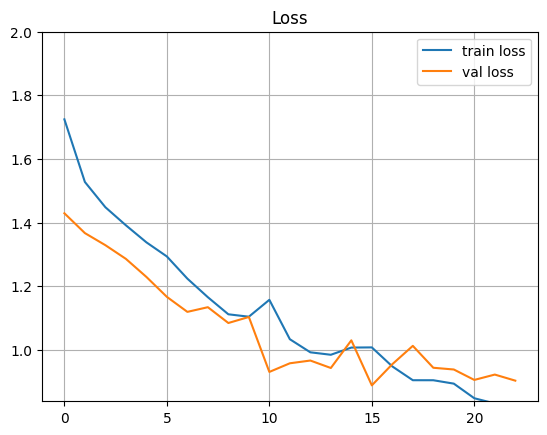

<Figure size 640x480 with 0 Axes>

In [256]:
### Evaluation LSTM
plot_loss(history_sel_LSTM.history,maxy=2.0)

In [257]:
model_sel_LSTM_b = load_model(MODEL_DIR+'/model_sel_LSTM.keras')
pred_sel_LSTM = model_sel_LSTM.predict(X_test)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


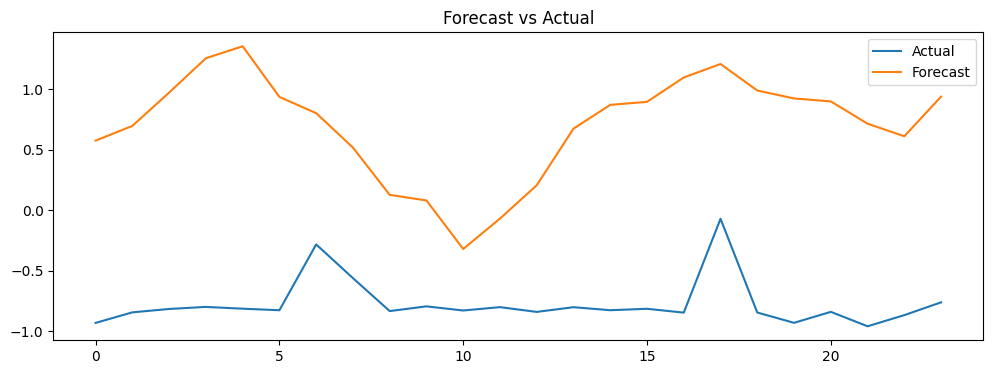

In [260]:
plot_forecast(y_test[0], pred_sel_LSTM[0])

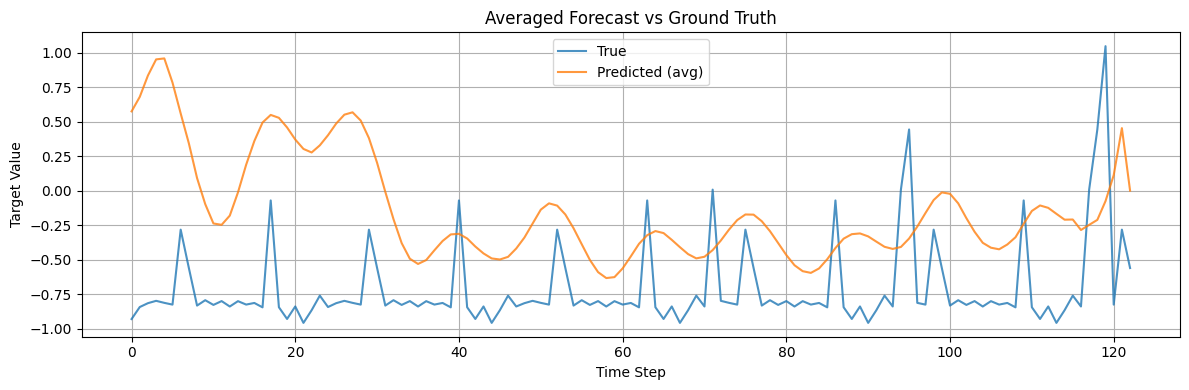

In [258]:
plot_average_forecast(y_test[:100], pred_sel_LSTM[0:100])

In [15]:
#  Build S2S Model

def build_S2S(encoder_input, decoder_input, units=64, dropout = 0.2, lr = 1e-4, l2=0.001):
    #Encoder
    encoder_input = layers.Input(shape=encoder_input.shape[1:], name='EncoderInput')
    encoder_lstm = layers.LSTM(units, return_state=True, name='Encoder', kernel_regularizer=regularizers.L2(l2))
    #Decoder
    decoder_input = layers.Input(shape=decoder_input.shape[1:], name='DecoderInput')
    decoder_lstm = layers.LSTM(units, return_sequences=True, name='Decoder', kernel_regularizer=regularizers.L2(l2))
    decoder_dropout = layers.Dropout(rate=dropout)
    decoder_dense = layers.Dense(1, name='DecoderDense', kernel_regularizer=regularizers.L2(l2))

    #IO
    _, state_h, state_c = encoder_lstm(encoder_input)
    decoder_output = decoder_lstm(decoder_input, initial_state=[state_h, state_c])
    droped_output = decoder_dropout(decoder_output)
    final_output = decoder_dense(droped_output)

    #Model
    model = Model(inputs=[encoder_input, decoder_input], outputs=final_output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model

In [16]:
delete_model('model_sel_S2S', 'history_sel_S2S')

decoder_input = np.zeros_like(y_model_sel)
decoder_input[:, 1:, :] = y_model_sel[:, :-1, :]

model_sel_S2S = build_S2S(X_model_sel, decoder_input)
model_sel_S2S.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ EncoderInput        │ (None, 168, 8)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecoderInput        │ (None, 24, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder (LSTM)      │ [(None, 64),      │     18,688 │ EncoderInput[0][… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder (LSTM)      │ (None, 24, 64)    │     16,896 │ DecoderInput[0][… │
│                     │                   │            │ Encoder[0][1],    │
│                     │                   │            │ Encoder[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 64)    │          0 │ Decoder[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecoderDense        │ (None, 24, 1)     │         65 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,649 (139.25 KB)

 Trainable params: 35,649 (139.25 KB)

 Non-trainable params: 0 (0.00 B)

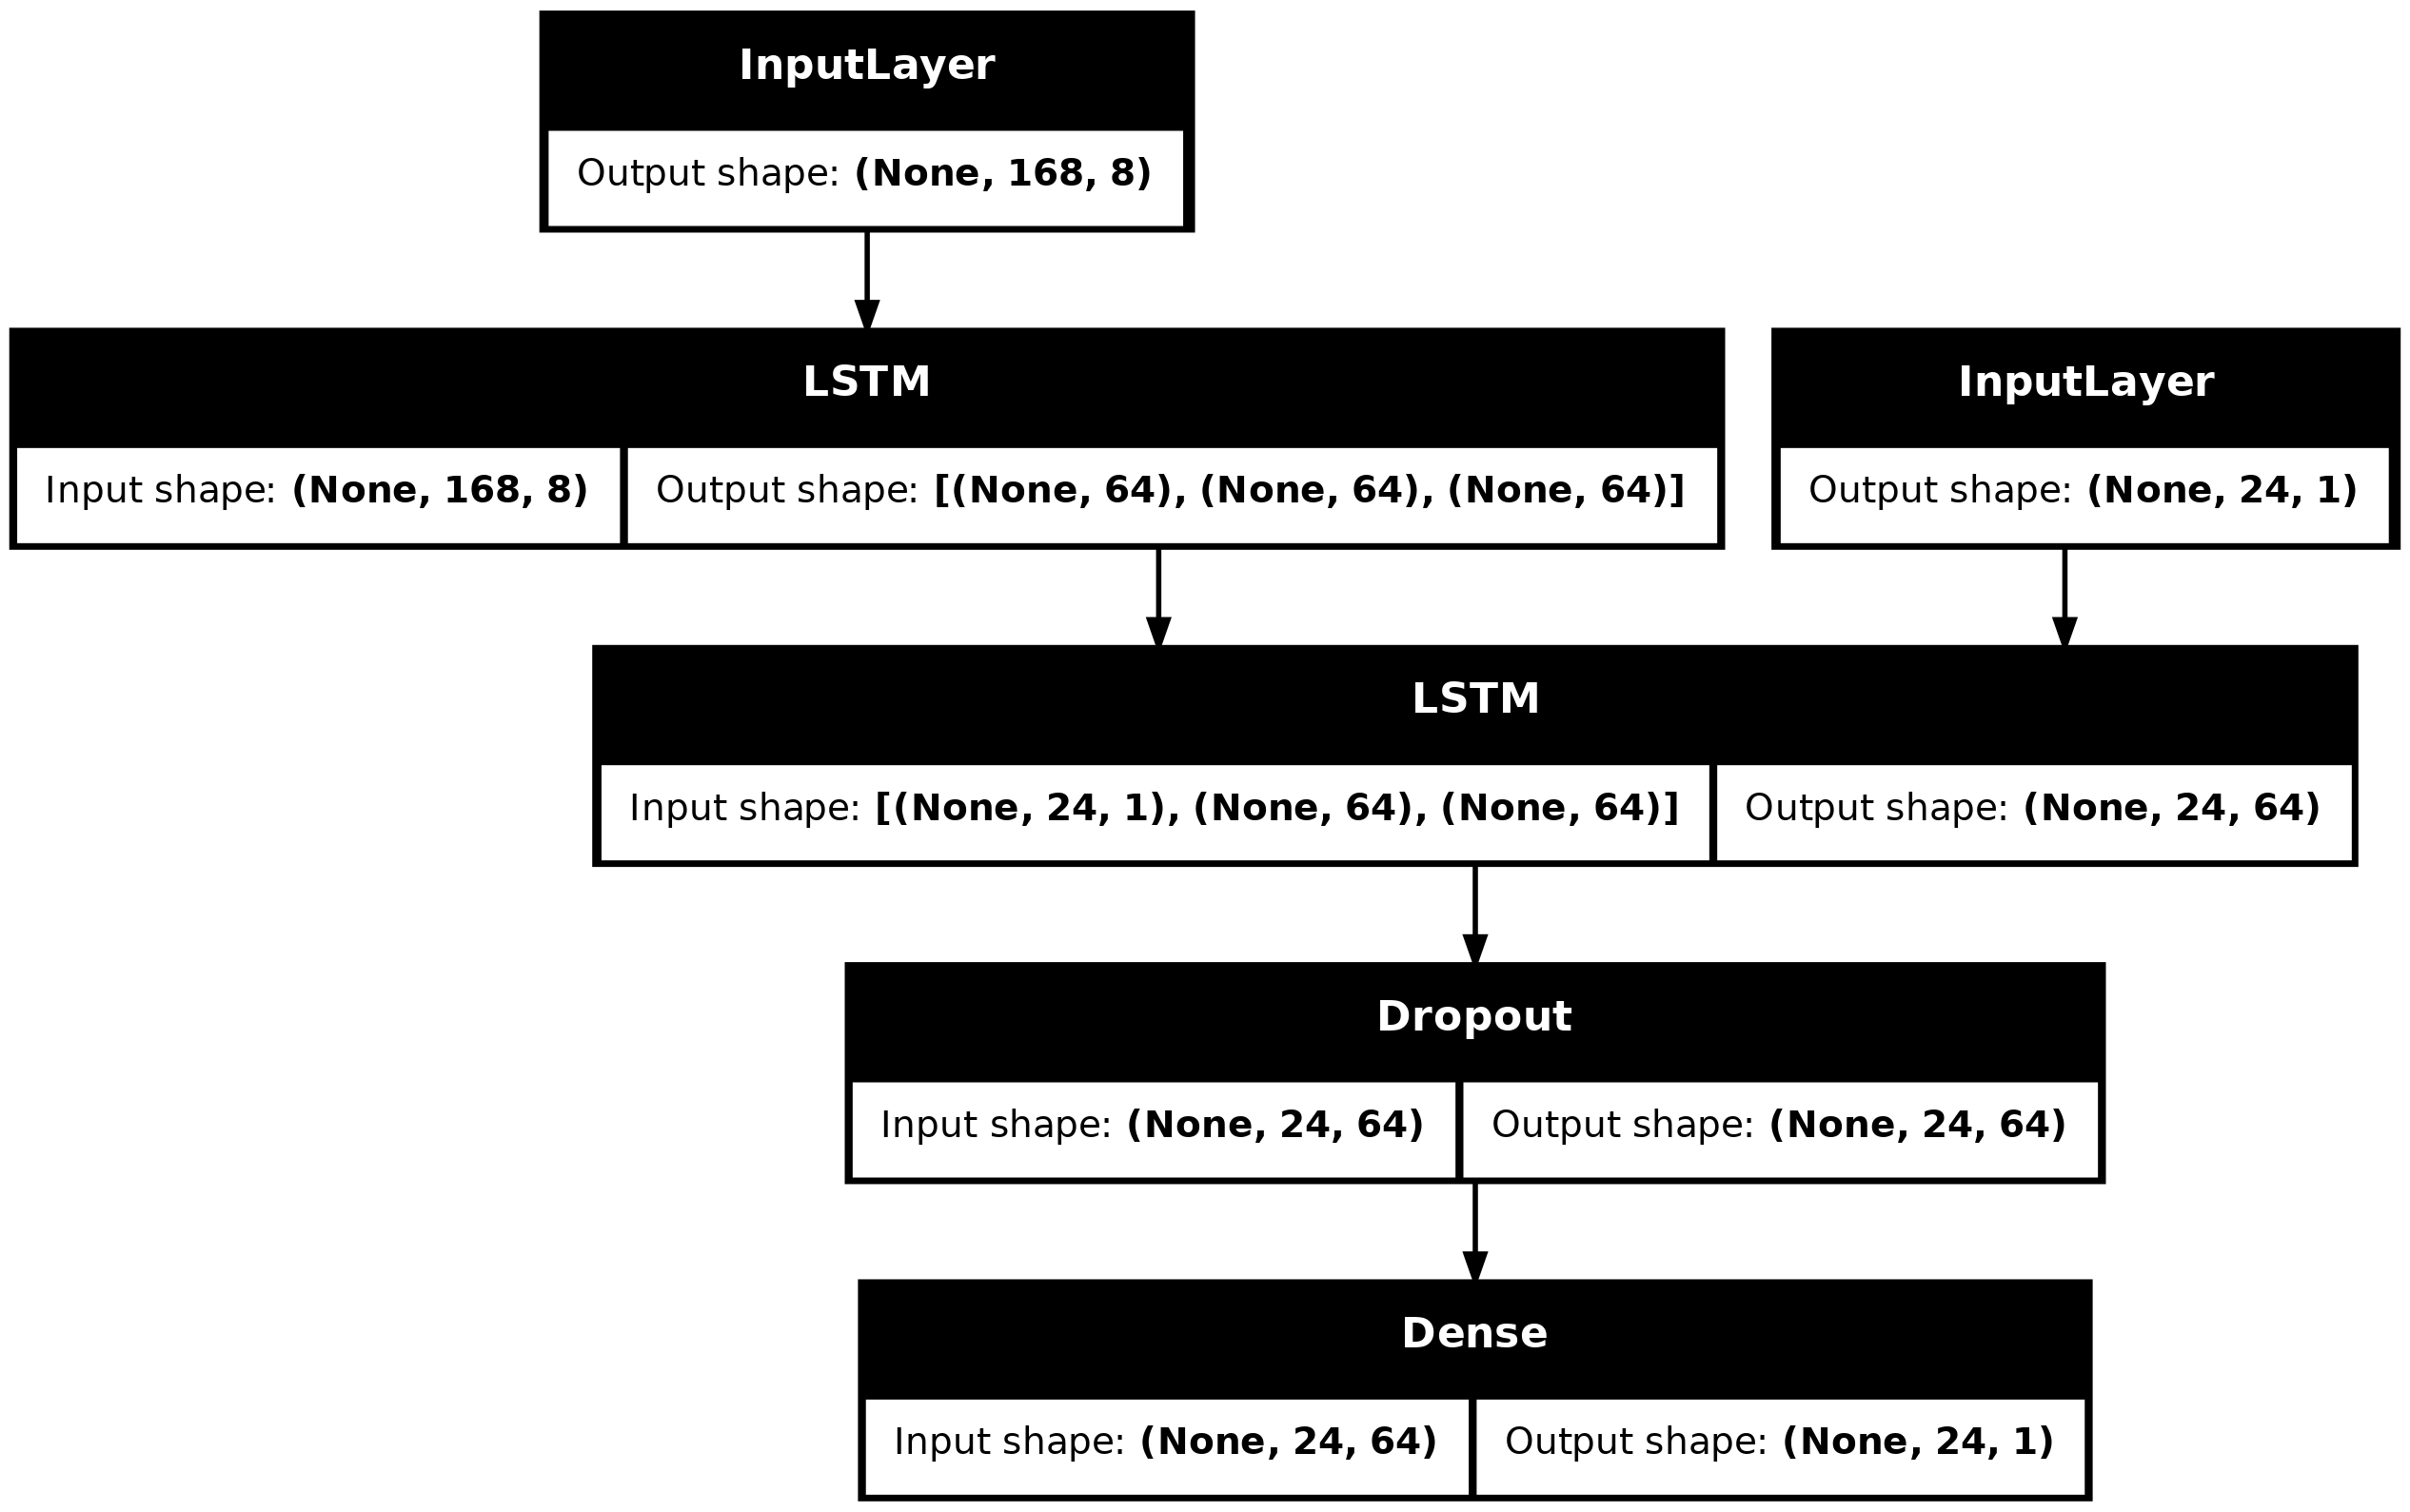

In [17]:
keras.utils.plot_model(model_sel_S2S, "S2S.png", show_shapes=True)

In [9]:
# Train S2S Model

history_sel_S2S = model_sel_S2S.fit(
    [X_model_sel, decoder_input],  
    y_model_sel,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks = [early_stop(7), check_point('model_sel_S2S')],
    shuffle=False
)

Epoch 1/100


I0000 00:00:1754063289.466053    8464 cuda_dnn.cc:529] Loaded cuDNN version 90300


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.3112 - mae: 1.1971 - val_loss: 1.5038 - val_mae: 0.9925
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.9480 - mae: 1.1143 - val_loss: 1.4397 - val_mae: 0.9900
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.6865 - mae: 1.0491 - val_loss: 1.4002 - val_mae: 0.9884
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.5333 - mae: 1.0113 - val_loss: 1.3570 - val_mae: 0.9742
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.4519 - mae: 0.9855 - val_loss: 1.3058 - val_mae: 0.9514
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.3947 - mae: 0.9628 - val_loss: 1.2606 - val_mae: 0.9308
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.3519 - mae: 0.9459 - val_loss: 1.2202 - val_mae: 0.9123
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.3061 - mae: 0.9272 - val_loss: 1.1826 - val_mae: 0.8952
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.2685 -

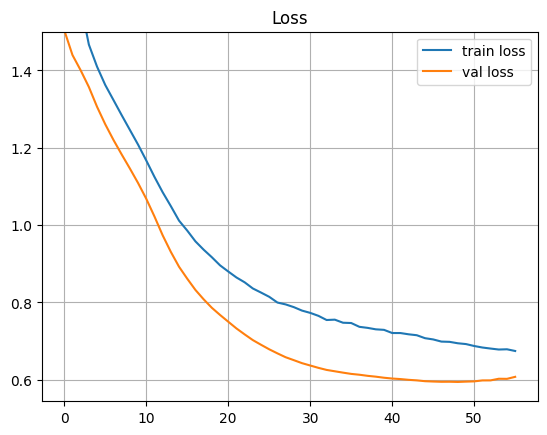

<Figure size 640x480 with 0 Axes>

In [259]:
# Evaluate S2S Model
plot_loss(history_sel_S2S.history, maxy=1.5)

In [239]:
model_sel_S2S_b = load_model(MODEL_DIR + '/model_sel_S2S.keras')

In [47]:
decoder_input_test = np.zeros_like(y_test)
decoder_input_test[:, 1:, :] = y_test[:, :-1, :]


In [241]:

pred_sel_S2S = model_sel_S2S_b.predict([X_test, decoder_input_test])

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


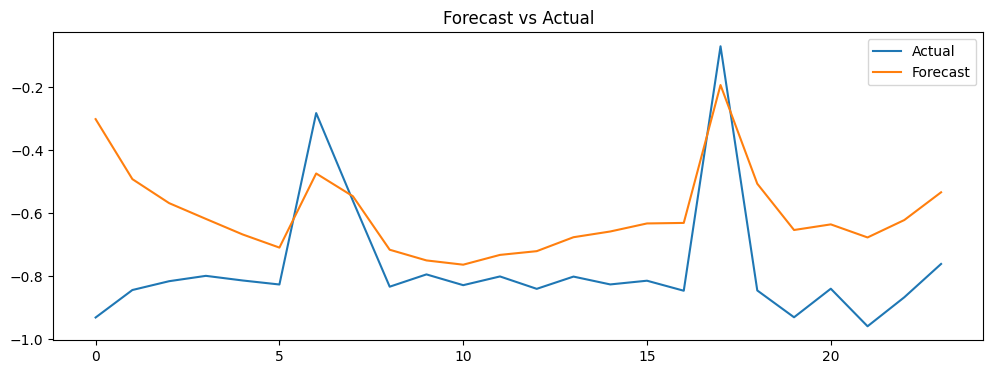

In [248]:
plot_forecast(y_test[0], pred_sel_S2S[1])

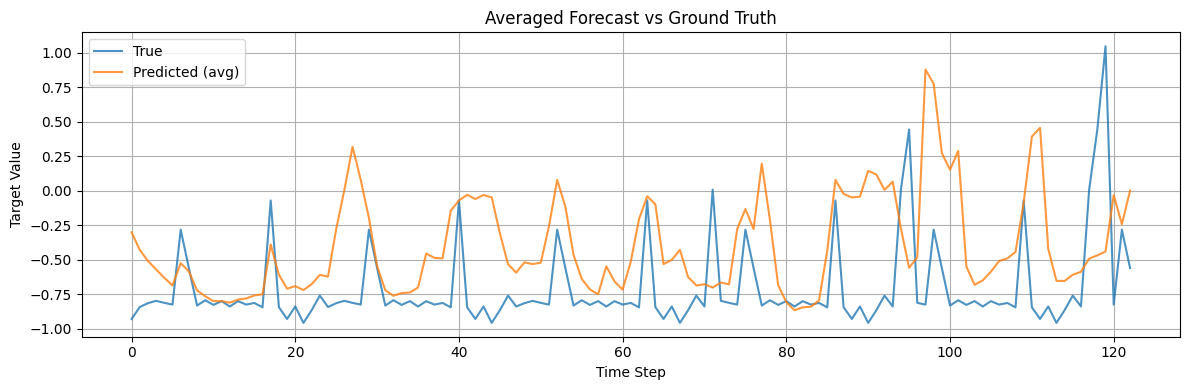

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2786 - mae: 0.3941


[0.28761324286460876, 0.3955540955066681]

In [251]:
plot_average_forecast(y_test[:100], pred_sel_S2S[1:101])
model_sel_S2S_b.evaluate([X_test, decoder_input_test], y_test)

## 3. Hyperparameter Tuning
The model selected is S2S for significantly better performance. 

### Hyperparameters
Hyperparameters to be tuned:
- `learning_rate: [5e-5, 1e-4, 2e-4, 3e-4, 5e-4]`
- `units: [16, 32]`
- `dropout: [0.3, 0.4, 0.5]`
- `batch_size: [16, 32]`
- `l2 [1e-4, 1e-3, 1e-2]`

### Train
Tune hyperparameters on `hparam_tuning` subset with `validation_split = 0.2`. 

When tuning, reduce EarlyStop patience to 10, limit 50 epochs. 

### Save Models Logs
- Save models in `model/tune`
 -Save logs in `log/hparam`

In [117]:
### Hyperparameter Tuning
# delete hyperparameter tuning logs
%rm -rf ./hparam/*


In [ ]:

%tensorboard --logdir hparam/log

In [ ]:
# Tuning hyperparameters 
#learning_rate: [5e-5, 1e-4, 2e-4, 3e-4, 5e-4]
#units: [16, 32]
#dropout: [0.3, 0.4, 0.5]
#batch_size: [16, 32]
#l2 [1e-4, 1e-3, 1e-2]

HP_LR = hp.HParam('learning_rate', hp.Discrete([5e-5, 1e-4, 2e-4, 3e-4, 5e-4]))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([16, 32]))

HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.3, 0.4, 0.5]))
HP_UNITS = hp.HParam('units', hp.Discrete([16, 32]))
HP_L2 = hp.HParam('l2', hp.Discrete([1e-4, 1e-3, 1e-2]))

METRIC_LOSS = 'loss'
METRIC_GAP = 'gap'


In [119]:

decoder_input_tune = np.zeros_like(y_tune)
decoder_input_tune[:, 1:, :] = y_tune[:, :-1, :]


In [120]:
def train_test_model(hparams, log_dir, round, id):
    model = build_S2S(
        X_tune,
        decoder_input_tune, 
        units=hparams[HP_UNITS], 
        dropout=hparams[HP_DROPOUT], 
        lr=hparams[HP_LR],
        l2=hparams[HP_L2],
    )
    history = model.fit(
        [X_tune, decoder_input_tune], 
        y_tune, 
        validation_split=0.2, 
        epochs=100, 
        batch_size=hparams[HP_BATCH_SIZE], 
        verbose=0, 
        callbacks=[
            check_point(f'round{round}/hparam_S2S_{id}', hparam=True),
            early_stop(7),
            TensorBoard(log_dir),
            hp.KerasCallback(log_dir, hparams)
        ]
    )
    train_loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']
    best_epoch = np.argmin(val_loss_history)
    min_train_loss = train_loss_history[best_epoch]
    min_val_loss = val_loss_history[best_epoch]

    loss_gap = abs(min_train_loss - min_val_loss)
    with tf.summary.create_file_writer(log_dir).as_default():
        tf.summary.scalar(METRIC_LOSS, min_val_loss, step=1)
        tf.summary.scalar(METRIC_GAP, loss_gap, step=1)

    # delete the model to free up VRAM
    delete_model('model', 'history')
    return train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap

In [121]:
# initiate tfboard log
with tf.summary.create_file_writer('hparam/log/round1').as_default():
    hp.hparams_config(
        hparams=[HP_LR, HP_BATCH_SIZE, HP_DROPOUT, HP_UNITS, HP_L2],
        metrics=[
            hp.Metric(METRIC_LOSS, display_name='MSE'), 
            hp.Metric(METRIC_GAP, display_name='Loss Gap')
        ],
    )


In [122]:
def run_hparam(session_num, hparams, round):
    run_name = f"run-{session_num}"
    print(f"--- Starting trial: {run_name}")
    print({h.name: hparams[h] for h in hparams})
    log_dir = f'hparam/log/round{round}/{run_name}'
    train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap = train_test_model(hparams, log_dir, round, session_num)
    print(f'best loss {min_train_loss, min_val_loss} found at epoch {best_epoch}, with gap {loss_gap}')

    return train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap


In [123]:

session_num1 = 0
results1 = []
# iterate among all hyperparameters to be tuned
for lr in HP_LR.domain.values:
    for batch in HP_BATCH_SIZE.domain.values:
        hparams1 = {
        HP_LR: lr,
        HP_BATCH_SIZE: batch,
        HP_DROPOUT: 0.4,
        HP_UNITS: 32,
        HP_L2: 1e-3,
    }
        train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap = run_hparam(session_num1, hparams1, round=1)
        results1.append((hparams1, train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap))
        session_num1 += 1


--- Starting trial: run-0
{'learning_rate': 5e-05, 'batch_size': 16, 'dropout': 0.4, 'units': 32, 'l2': 0.001}
best loss (0.5083132982254028, 0.4310385286808014) found at epoch 51, with gap 0.07727476954460144
--- Starting trial: run-1
{'learning_rate': 5e-05, 'batch_size': 32, 'dropout': 0.4, 'units': 32, 'l2': 0.001}
best loss (0.4935546815395355, 0.4074104428291321) found at epoch 96, with gap 0.08614423871040344
--- Starting trial: run-2
{'learning_rate': 0.0001, 'batch_size': 16, 'dropout': 0.4, 'units': 32, 'l2': 0.001}
best loss (0.5164852142333984, 0.4107359051704407) found at epoch 20, with gap 0.10574930906295776
--- Starting trial: run-3
{'learning_rate': 0.0001, 'batch_size': 32, 'dropout': 0.4, 'units': 32, 'l2': 0.001}
best loss (0.5738487243652344, 0.467883825302124) found at epoch 29, with gap 0.10596489906311035
--- Starting trial: run-4
{'learning_rate': 0.0002, 'batch_size': 16, 'dropout': 0.4, 'units': 32, 'l2': 0.001}
best loss (0.49106332659721375, 0.4056856632232

In [124]:
# display hyperparameter tuning result
def catch_hparam_result(results):
    rows = []
    train_loss_tune = []
    val_loss_tune = []
    for hparams, train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap in results:
        row = {h.name: hparams[h] for h in hparams}
        row['best_epoch'] = best_epoch
        row['min_train_loss'] = min_train_loss
        row['min_val_loss'] = min_val_loss
        row['loss_gap'] = loss_gap
        rows.append(row)
        train_loss_tune.append(train_loss_history)
        val_loss_tune.append(val_loss_history)
        # print(len(train_loss_history))
    df = pd.DataFrame(rows).sort_values(by='min_val_loss')
    return df, train_loss_tune, val_loss_tune


In [130]:
df1, train_loss_tune1, val_loss_tune1 = catch_hparam_result(results1)
df1[:10]

,learning_rate,batch_size,dropout,units,l2,best_epoch,min_train_loss,min_val_loss,loss_gap
6,0.00030,16,0.4,32,0.001,9,0.516228,0.401348,0.114880
4,0.00020,16,0.4,32,0.001,14,0.491063,0.405686,0.085378
1,0.00005,32,0.4,32,0.001,96,0.493555,0.407410,0.086144
2,0.00010,16,0.4,32,0.001,20,0.516485,0.410736,0.105749
5,0.00020,32,0.4,32,0.001,24,0.511444,0.425319,0.086125
9,0.00050,32,0.4,32,0.001,9,0.504330,0.426286,0.078044
0,0.00005,16,0.4,32,0.001,51,0.508313,0.431039,0.077275
8,0.00050,16,0.4,32,0.001,4,0.521909,0.433010,0.088899
3,0.00010,32,0.4,32,0.001,29,0.573849,0.467884,0.105965
7,0.00030,32,0.4,32,0.001,6,0.645929,0.534720,0.111209


In [139]:
df_filtered1 = df1[df1['best_epoch'] > 15]
df_filtered11 = df_filtered1[df_filtered1['loss_gap'] < 0.1]
best_param1 = df_filtered1.loc[df_filtered1['min_val_loss'].idxmin()]
best_param1

learning_rate      0.000050
batch_size        32.000000
dropout            0.400000
units             32.000000
l2                 0.001000
best_epoch        96.000000
min_train_loss     0.493555
min_val_loss       0.407410
loss_gap           0.086144
Name: 1, dtype: float64

In [140]:
# save best hyperparameters

BEST_LR = best_param1['learning_rate']
BEST_BATCH_SIZE = int(best_param1['batch_size'])
BEST_NAME1 = best_param1.name
# use tuned best hyperparameters if didn't run tuning

# BEST_LR = 5e-4
# BEST_BATCH_SIZE = 64
# BEST_NAME1 = 33

In [145]:
best_history1 = pd.DataFrame({
        'loss': train_loss_tune1[BEST_NAME1],
        'val_loss': val_loss_tune1[BEST_NAME1]
    })

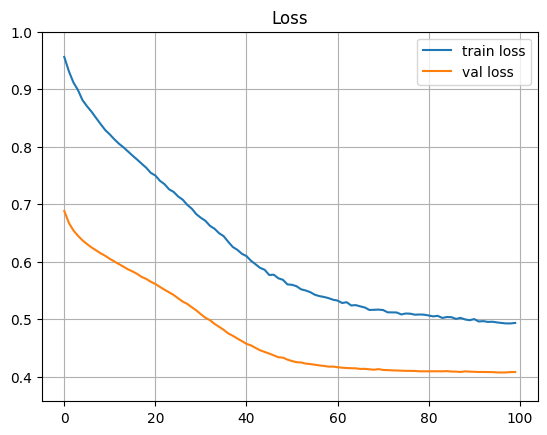

<Figure size 640x480 with 0 Axes>

In [146]:
plot_loss(best_history1, maxy=1.0)

In [148]:
# initiate tfboard log
with tf.summary.create_file_writer('hparam/log/round2').as_default():
    hp.hparams_config(
        hparams=[HP_LR, HP_BATCH_SIZE, HP_DROPOUT, HP_UNITS, HP_L2],
        metrics=[
            hp.Metric(METRIC_LOSS, display_name='MSE'), 
            hp.Metric(METRIC_GAP, display_name='Loss Gap')
        ],
    )


In [149]:

session_num2 = 0
results2 = []

for dropout in HP_DROPOUT.domain.values:
    for units in HP_UNITS.domain.values:
        for l2 in HP_L2.domain.values:
            hparams2 = {
                HP_LR: BEST_LR,
                HP_BATCH_SIZE: BEST_BATCH_SIZE,
                HP_DROPOUT: dropout,
                HP_UNITS: units,
                HP_L2: l2,
            }
            train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap = run_hparam(session_num2, hparams2, round=2)
            results2.append((hparams2, train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap))
            session_num2 += 1


--- Starting trial: run-0
{'learning_rate': np.float64(5e-05), 'batch_size': 32, 'dropout': 0.3, 'units': 16, 'l2': 0.0001}
best loss (0.5165717601776123, 0.3912668228149414) found at epoch 99, with gap 0.1253049373626709
--- Starting trial: run-1
{'learning_rate': np.float64(5e-05), 'batch_size': 32, 'dropout': 0.3, 'units': 16, 'l2': 0.001}
best loss (0.517731249332428, 0.40136319398880005) found at epoch 98, with gap 0.11636805534362793
--- Starting trial: run-2
{'learning_rate': np.float64(5e-05), 'batch_size': 32, 'dropout': 0.3, 'units': 16, 'l2': 0.01}
best loss (0.5681928396224976, 0.43915024399757385) found at epoch 99, with gap 0.1290425956249237
--- Starting trial: run-3
{'learning_rate': np.float64(5e-05), 'batch_size': 32, 'dropout': 0.3, 'units': 32, 'l2': 0.0001}
best loss (0.5333927273750305, 0.43806028366088867) found at epoch 47, with gap 0.09533244371414185
--- Starting trial: run-4
{'learning_rate': np.float64(5e-05), 'batch_size': 32, 'dropout': 0.3, 'units': 32, '

In [152]:
# display hyperparameter tuning result
df2, train_loss_tune2, val_loss_tune2 = catch_hparam_result(results2)
df2[:10]

,learning_rate,batch_size,dropout,units,l2,best_epoch,min_train_loss,min_val_loss,loss_gap
0,0.00005,32,0.3,16,0.0001,99,0.516572,0.391267,0.125305
9,0.00005,32,0.4,32,0.0001,72,0.500943,0.396277,0.104666
12,0.00005,32,0.5,16,0.0001,99,0.562751,0.397832,0.164919
1,0.00005,32,0.3,16,0.0010,98,0.517731,0.401363,0.116368
4,0.00005,32,0.3,32,0.0010,82,0.493308,0.401646,0.091662
6,0.00005,32,0.4,16,0.0001,99,0.544086,0.402381,0.141705
7,0.00005,32,0.4,16,0.0010,99,0.587868,0.420931,0.166938
10,0.00005,32,0.4,32,0.0010,66,0.519934,0.430814,0.089120
5,0.00005,32,0.3,32,0.0100,99,0.531329,0.432905,0.098424
11,0.00005,32,0.4,32,0.0100,96,0.550642,0.435146,0.115496


In [153]:
df_filtered2 = df2[df2['best_epoch'] > 20]
best_param2 = df_filtered2.loc[df_filtered2['min_val_loss'].idxmin()]
best_param2

learning_rate      0.000050
batch_size        32.000000
dropout            0.300000
units             16.000000
l2                 0.000100
best_epoch        99.000000
min_train_loss     0.516572
min_val_loss       0.391267
loss_gap           0.125305
Name: 0, dtype: float64

In [154]:
# save best hyperparameters

BEST_DROPOUT = best_param2['dropout']
BEST_UNITS = int(best_param2['units'])
BEST_L2 = best_param2['l2']
BEST_NAME2 = best_param2.name
# use tuned best hyperparameters if didn't run tuning

# BEST_DROPOUT = 0.5
# BEST_UNITS = 16
# BEST_L2 = 1e-3
# BEST_NAME2 = 33

In [155]:
best_history2 = pd.DataFrame({
        'loss': train_loss_tune2[BEST_NAME2],
        'val_loss': val_loss_tune2[BEST_NAME2]
    })

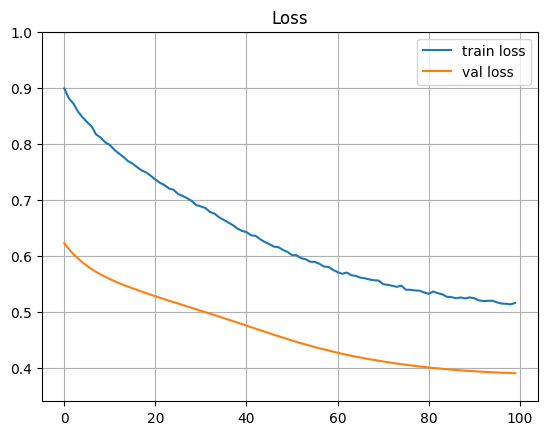

<Figure size 640x480 with 0 Axes>

In [156]:
plot_loss(best_history2, maxy=1.0)

In [157]:
best_model = load_model(f'hparam/model/round2/hparam_S2S_{BEST_NAME2}.keras')
best_y_pred = best_model.predict([X_test, decoder_input_test])
best_model.evaluate([X_test, decoder_input_test], y_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2379 - mae: 0.3776


[0.2455555945634842, 0.37340858578681946]

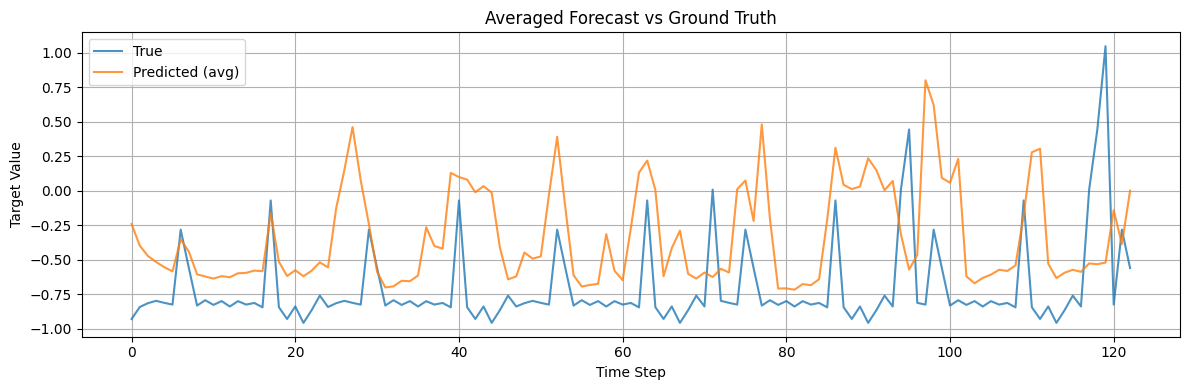

In [190]:
plot_average_forecast(y_test[:100], best_y_pred[:100])

## 4. Model Train and Evaluation

### Train Tuned Model
Train model on `train` subset with `validation_split = 0.2`. 

### Save Model
Save model in `model`. 

### Evaluate Model
Use `test` subset to evaluate model with metrics $\mathrm{RMSE}$ and $\mathrm{MAE}$. 

### Visualization
Plots to be visualized
- Actual vs Predicted 
- Loss over Epochs

### Analyze Model Performance


In [220]:
### Train Tuned Model

train_decoder = np.zeros_like(y_train)
train_decoder[:, 1:, :] = y_train[:, :-1, :]


In [221]:
delete_model('final_model', 'final_history')
final_model = build_S2S(X_train[1:], train_decoder[1:], units = BEST_UNITS, dropout=BEST_DROPOUT, lr=BEST_LR, l2=BEST_L2)
final_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ EncoderInput        │ (None, 168, 11)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecoderInput        │ (None, 24, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder (LSTM)      │ [(None, 16),      │      1,792 │ EncoderInput[0][… │
│                     │ (None, 16),       │            │                   │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder (LSTM)      │ [(None, 24, 16),  │      1,152 │ DecoderInput[0][… │
│                     │ (None, 16),       │            │ Encoder[0][1],    │
│                     │ (None, 16)]       │            │ Encoder[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 16)    │          0 │ Decoder[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecoderDense        │ (None, 24, 1)     │         17 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,961 (11.57 KB)

 Trainable params: 2,961 (11.57 KB)

 Non-trainable params: 0 (0.00 B)

In [222]:
final_history = final_model.fit(
    [X_train[1:], train_decoder[1:]], 
    y_train[1:], 
    validation_split=0.2, 
    epochs=200, 
    batch_size=BEST_BATCH_SIZE, 
    callbacks=[
        check_point(f'final_S2S'),
        early_stop(7),
    ]
)

Epoch 1/200
434/434 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 1.0968 - mae: 0.8518 - val_loss: 0.7886 - val_mae: 0.7144
Epoch 2/200
434/434 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.9481 - mae: 0.7784 - val_loss: 0.7219 - val_mae: 0.6761
Epoch 3/200
434/434 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.8539 - mae: 0.7233 - val_loss: 0.6617 - val_mae: 0.6404
Epoch 4/200
434/434 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.7867 - mae: 0.6844 - val_loss: 0.6110 - val_mae: 0.6084
Epoch 5/200
434/434 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.7332 - mae: 0.6528 - val_loss: 0.5720 - val_mae: 0.5809
Epoch 6/200
434/434 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.6927 - mae: 0.6285 - val_loss: 0.5421 - val_mae: 0.5595
Epoch 7/200
434/434 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.6642 - mae: 0.6100 - val_loss: 0.5186 - val_mae: 0.5412
Epoch 8/200
434/434 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.6297 - mae: 0.5888 - val_loss: 0.5003 - val_mae: 0.5281
Epoch 9/200
434/434 ━━━━━━━━━━━━━━━━━

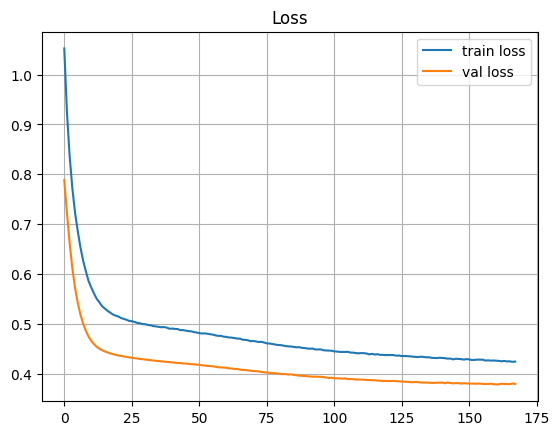

<Figure size 640x480 with 0 Axes>

In [223]:
plot_loss(final_history.history)

In [18]:
final_model = load_model('model/final_S2S.keras')

In [225]:
### Evaluate Model
final_model.evaluate([X_test, decoder_input_test], y_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2026 - mae: 0.3219


[0.2046133130788803, 0.31622496247291565]

In [226]:
train_pred = final_model.predict([X_train, train_decoder])

542/542 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step


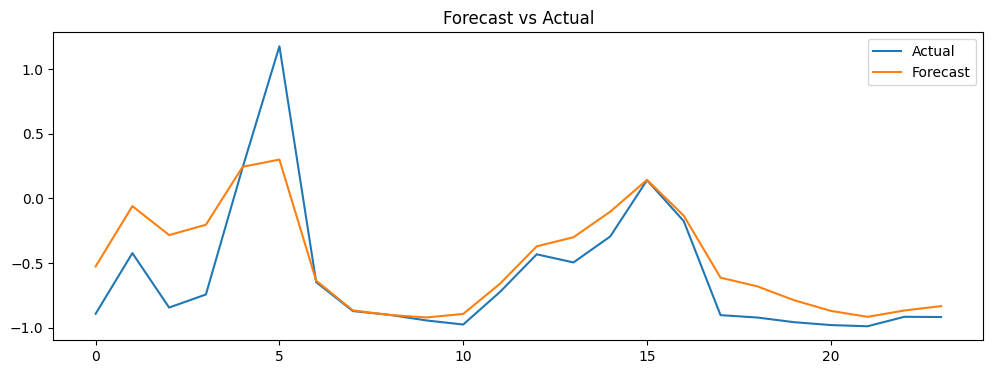

In [227]:
plot_forecast(y_train[0], train_pred[1])

In [48]:
final_pred = final_model.predict([X_test, decoder_input_test])

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step   

I0000 00:00:1754262566.727811    2988 cuda_dnn.cc:529] Loaded cuDNN version 90300


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


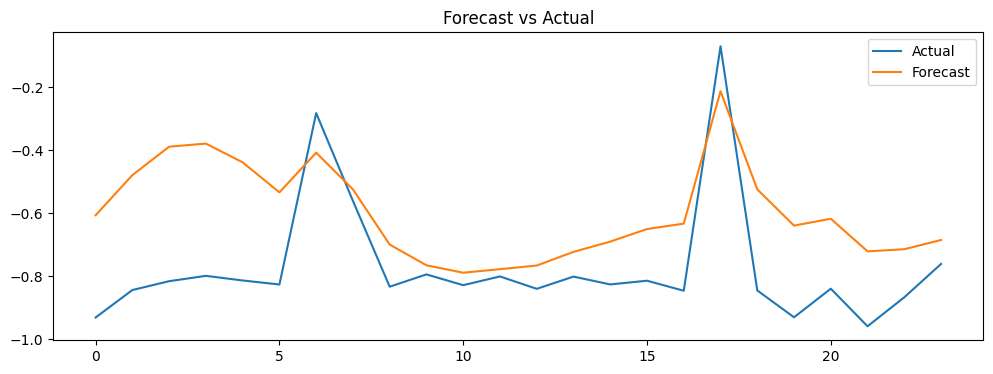

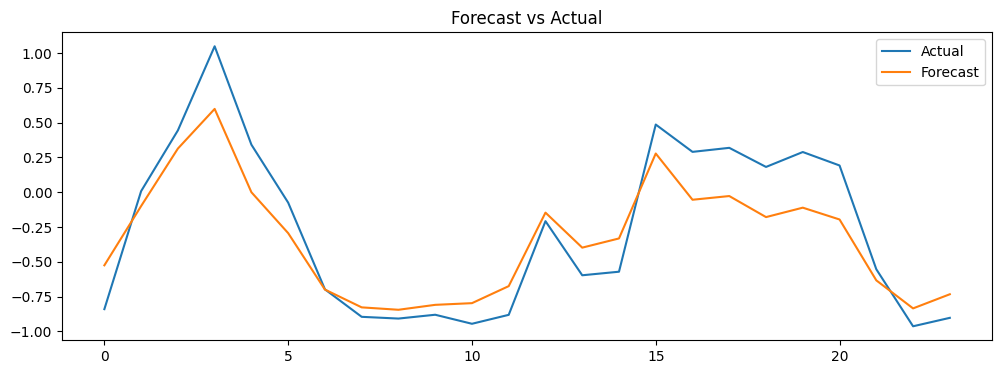

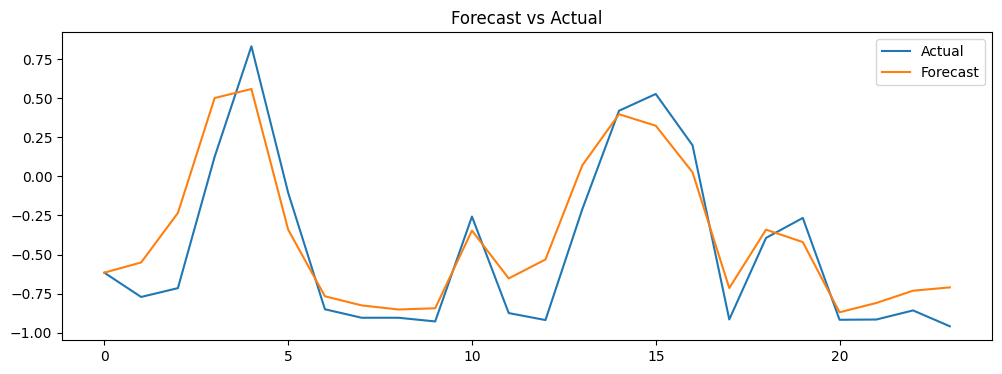

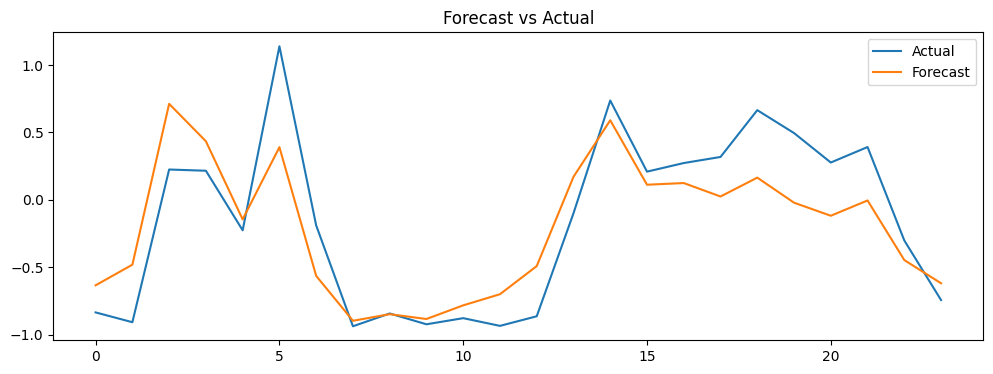

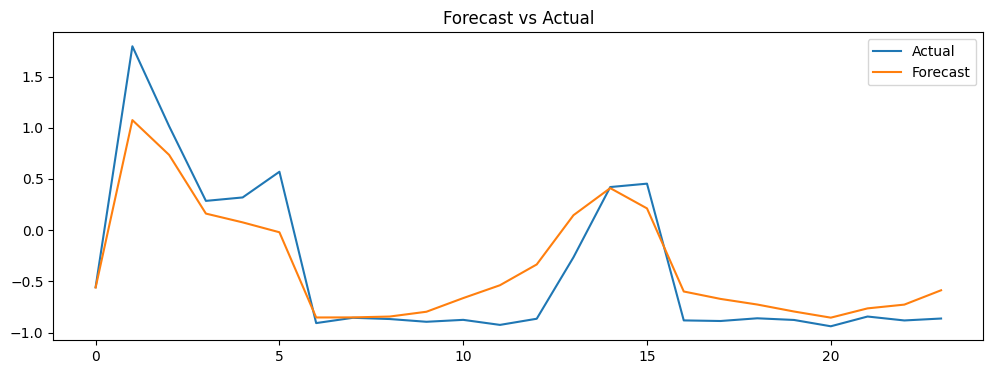

In [49]:
for i in range(5):
    plot_forecast(y_test[i*24], final_pred[i*24+1])

In [50]:
y_test[1:-1,:-1,:].squeeze().shape, final_pred[1:-1,1:,:].squeeze().shape

((1967, 23), (1967, 23))

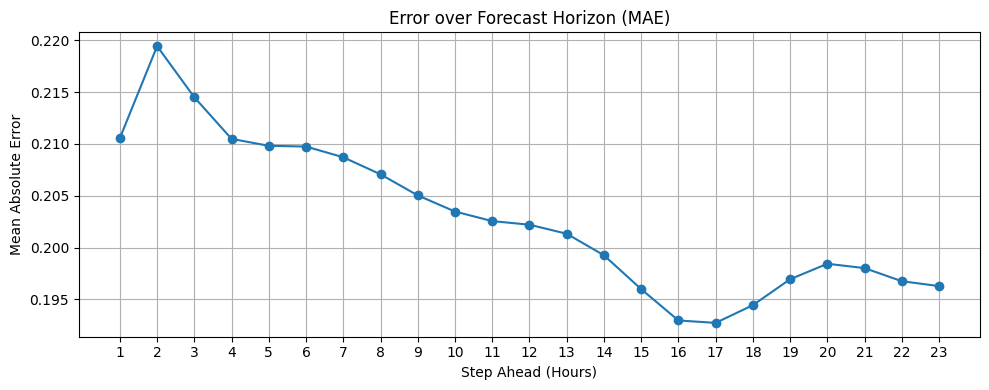

In [51]:
plot_forecast_error(y_test[:,:-1,:], final_pred[:,1:,:])

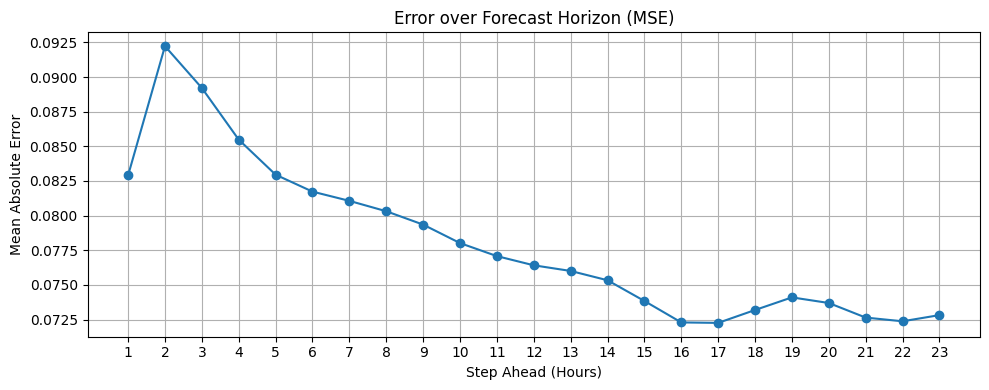

In [53]:
plot_forecast_MSE(y_test[:,:-1,:], final_pred[:,1:,:])

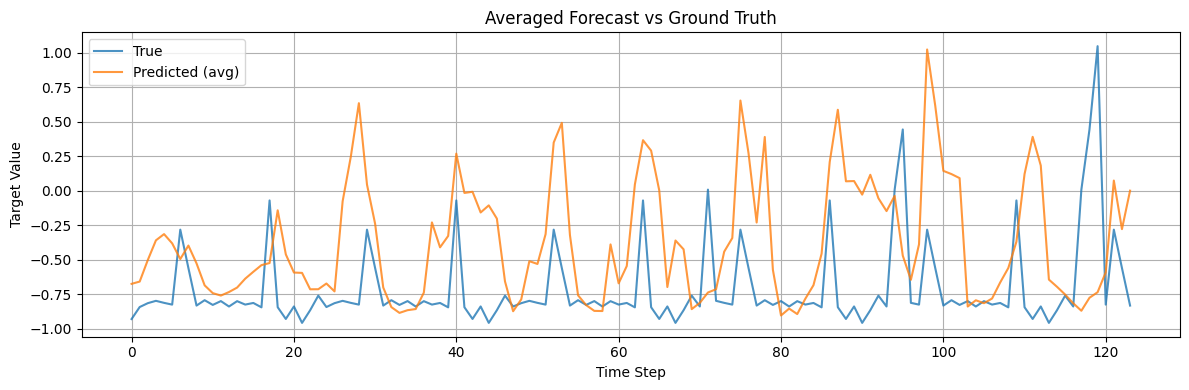

In [275]:
plot_average_forecast(y_test[0:100], final_pred[0:101])

In [124]:
### Visualization

In [125]:
### Analyze Model Performance


## 5. Forecaste to Energy Optimization

### Use `test1` and `test2` subset, take one day/week ahead, predict the `global_active_power` of the subset. 

### Merics
RMSE, MAE

### Visualize Result
Predicted vs Actual


In [328]:
start_time_1 = df_hourly_reco.iloc[27000+168].name
start_time_2 = df_hourly_reco.iloc[27000+2160+2160+168].name


In [391]:
def multi_round_forecast(model, initial_input, forecast_steps, forecast_horizon=24):
    """
    initial_input: shape (1, lag, features)
    forecast_steps: total number of days to predict
    forecast_horizon: number of hours predicted per model call
    """
    input_seq = initial_input.copy()  # shape: (1, lag, features)
    predictions = []
    encoder_input = np.zeros((1, 168, 11), dtype=np.float32)
    decoder_input = np.zeros((1, forecast_horizon, 1), dtype=np.float32)
    for _ in range(forecast_steps):
        # Predict next 24
        encoder_input[0,:,:] = input_seq[forecast_steps*forecast_horizon,:,:]
        y_pred = model.predict([encoder_input, decoder_input], verbose=0)
        decoder_input[0, 1:, 0] = y_pred[0, :-1, 0]
        predictions.append(y_pred.squeeze())

    return np.concatenate(predictions)

In [392]:
forecast1 = multi_round_forecast(final_model, X_test1, 1)
forecast2 = multi_round_forecast(final_model, X_test2, 7)

In [406]:
def plot_multi_forecast(y_true, y_pred):
    all_true = y_true[:len(y_pred),0,0]
    print(all_true.shape)
    time_index = pd.date_range(start=start_time_1, periods=len(y_pred), freq='h')  # adjust start

    plt.figure(figsize=(14, 5))
    plt.plot(time_index, all_true, label="Actual")
    plt.plot(time_index, y_pred, label="Forecast")
    plt.title("Continuous Forecast over Full Period")
    plt.xlabel("Time")
    plt.ylabel("Global Active Power")
    plt.legend()
    plt.tight_layout()
    plt.show()

(24,)


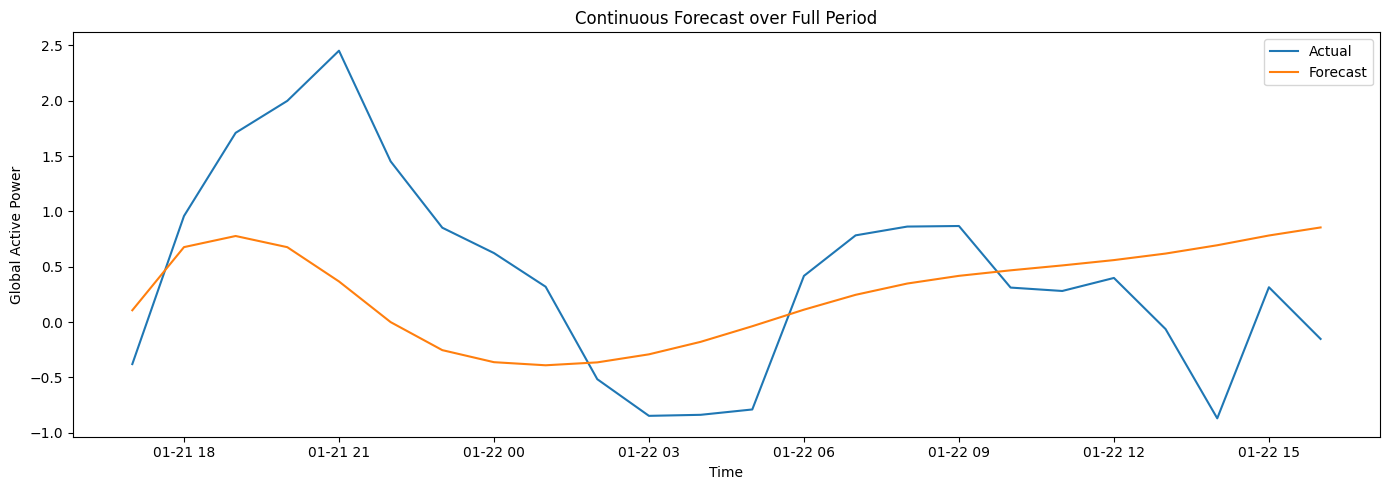

In [407]:
plot_multi_forecast(y_test1, forecast1)

(168,)


/tmp/ipykernel_1961/2929787854.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start=start_time_1, periods=len(y_pred), freq='H')  # adjust start


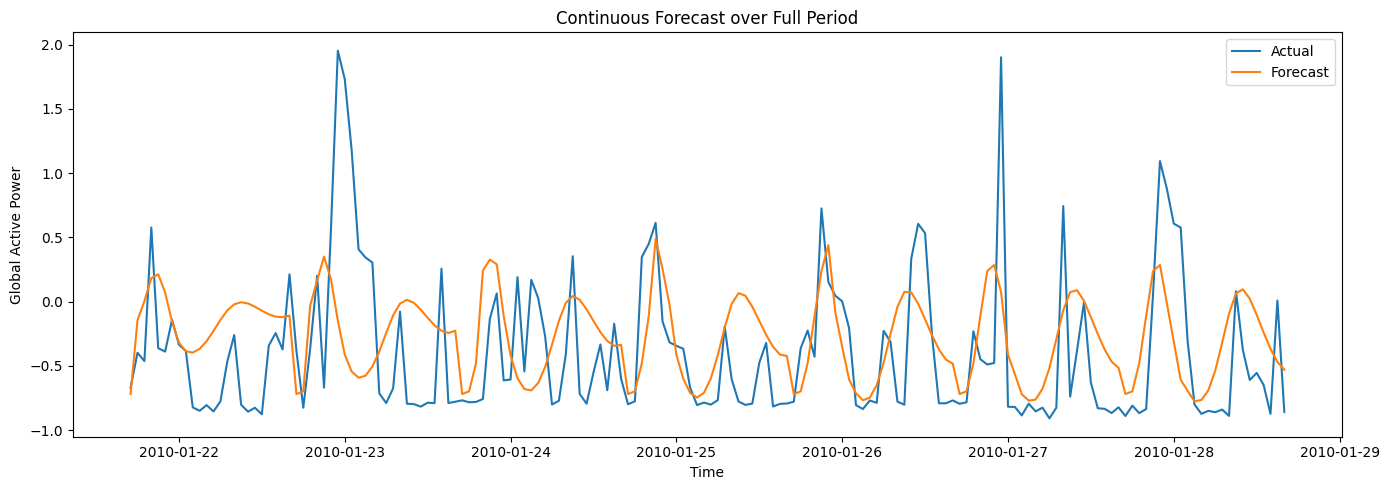

In [395]:
plot_multi_forecast(y_test2, forecast2)

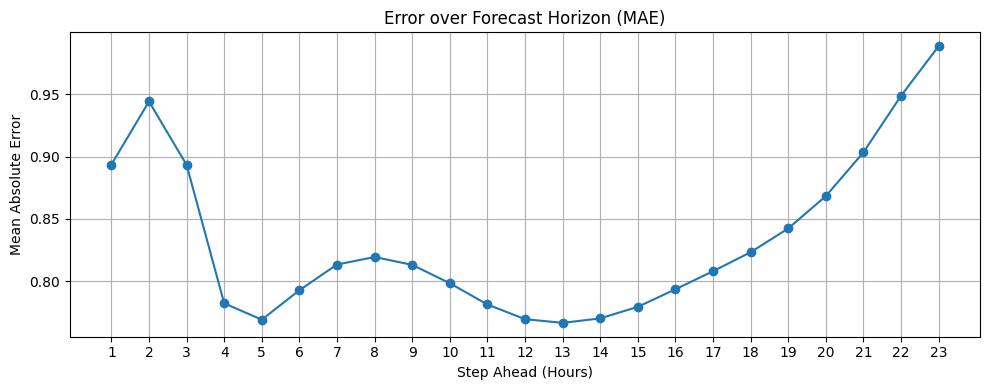

In [398]:
plot_forecast_error(y_test1[:, :-1,:], forecast1[1:])

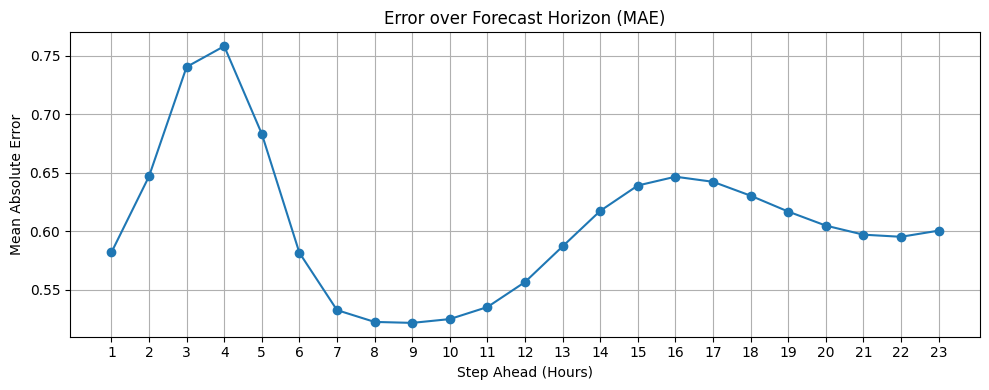

In [400]:
plot_forecast_error(y_test2[:, :-1,:], forecast2[1:24])